In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import util

# set defaults
plt.style.use('seaborn-white')   # seaborn custom plot style
plt.rc('figure', dpi=100, figsize=(7, 5))   # set default size/resolution
plt.rc('font', size=12)   # font size

# Feature Engineering


### Outline

* What is a feature?
* Feature Engineering.
* Designing features for a model: what kind of features you built depends on what kind of data you have: nominal, ordinal etc


## What have we done so far?

* Data assessment and collection:
    * The data generating processes and its relationship to observed data.
    * Data collection techniques (web-scraping, apis)
* Data cleaning and manipulation
    * Pandas and Regex
* Learned ways of understanding and summarizing data
    * Exploratory Data Analysis, visualization, TF-IDF

## Features

* A **feature** is a measurable property or characteristic of a phenomenon being observed.
* Synonyms: (explanatory) variable, attribute
* Examples include:
    - a column of a dataset.
    - a derived value from a dataset, perhaps using additional information.
    
We have been creating features to summarize data!

### Examples of features in SD salary dataset

* Salary of employee
* Employee salaries, standardized by job status (PT/FT)
* Gender/age of employees (derived from SSA names; accurate?)
* Job Family associated to a job title (uses text-techniques)

## What makes a good feature?

* Fidelity to Data Generating Process (Consistency).
* Strongly associated to phenomenon of interest ("contains information").
* Easily used in standard modeling techniques (e.g. quantitative and scaled).

Datasets often come with weak attributes; features may need to be "engineered" to convey information.

## Feature Engineering

* We already engineered features to summarize and understand data.
    - smoothing, transformations, ad hoc derived properties of data

* What can we do with it?
    - Visualization and summarization
    - Modeling (prediction; inference)

# Features in Linear Models

## Predicting child heights

* Recall, Francis Galton's obsession with understanding inheritance.
* He wanted to predict a child's *height* from their attributes of their parents.
    - attributes: family id, father height, mother height, number of children, gender, child height.

In [2]:
galton = pd.read_csv('data/galton.csv')
galton.head()

,family,father,mother,children,childNum,gender,childHeight
0,1,78.5,67.0,4,1,male,73.2
1,1,78.5,67.0,4,2,female,69.2
2,1,78.5,67.0,4,3,female,69.0
3,1,78.5,67.0,4,4,female,69.0
4,2,75.5,66.5,4,1,male,73.5


### Heights data: quick EDA
* What could be done to improve this viz?
* Is a linear model suitable for prediction? on which attributes?
* There are multiple granularities (what?); is this a problem?

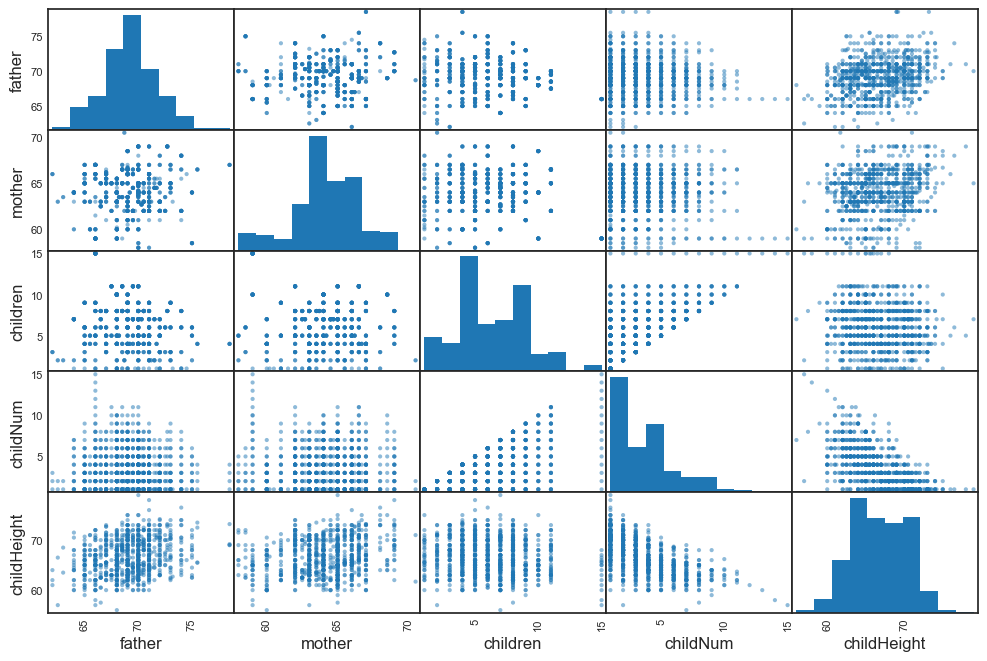

In [3]:
pd.plotting.scatter_matrix(galton, figsize=(12,8));

### Attempt #1: Predict child's height using father's height

1. Plot a scatterplot with a best-fit line and prediction interval

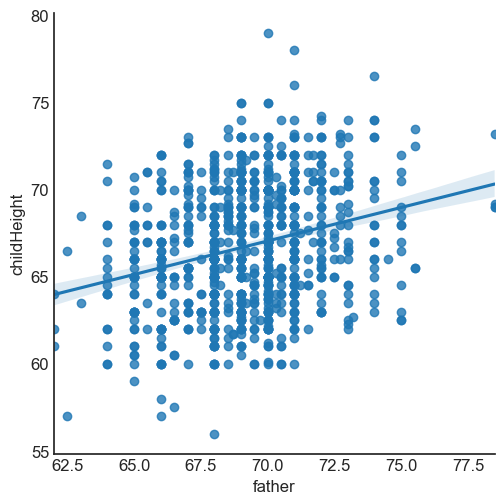

In [4]:
sns.lmplot(x='father', y='childHeight', data=galton);

### Attempt #1: Predict child's height using father's height

Let's do the prediction "by hand":

* Recall, a prediction is a function $pred$ from the *features* (father height) to the *target* (child height).
* The quality of our prediction on the dataset is the *root mean square error* (RMSE): $${\rm RMSE} =  \sqrt{\frac{1}{N}{\sum_{i=0}^{N}(pred(x_i) - y_i)^2}} $$ where $x_i$ are the father heights, $pred(x_i)$ are the predicted child heights, and $y_i$ are the *actual* child heights.

In [5]:
from scipy.stats import linregress

lm = linregress(galton.father, galton.childHeight)
lm

LinregressResult(slope=0.38450503160660643, intercept=40.13929481452019, rvalue=0.2660385389227191, pvalue=1.3498077148871314e-16, stderr=0.04563621404432861, intercept_stderr=3.159913648126035)

In [6]:
def pred_height(father):
    return lm.slope * father + lm.intercept

In [7]:
pred_height(60)

63.20959671091658

In [8]:
pred_height(galton.father).head()

0    70.322940
1    70.322940
2    70.322940
3    70.322940
4    69.169425
Name: father, dtype: float64

In [9]:
rmse = np.sqrt(np.mean((pred_height(galton.father) - galton.childHeight)**2))
rmse

3.448416023826754

### Visualizing the predictions
* How is our model good? bad?
    - Is a linear model appropriate? good?
    - How might we make it better?

<AxesSubplot:xlabel='father', ylabel='childHeight'>

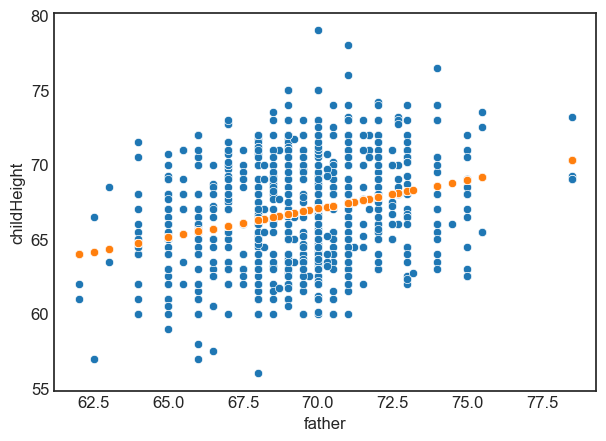

In [10]:
sns.scatterplot(
    x='father', y='childHeight', data=galton
)

sns.scatterplot(
    x=galton.father,
    y=pred_height(galton.father)
)

### Attempt #2: adding features

* What if the father is very tall and the mother is short?
* Will adding mother's height help our predictions?
* Try: regression on two variables (mother/father height).
    - "plane of best fit"

In [11]:
# use sklearn
from sklearn.linear_model import LinearRegression

In [12]:
# typical pattern; focus on this later!

lr = LinearRegression() # initial linear regression

lr.fit(galton[['mother', 'father']], galton.childHeight) # calculate the weights

predictions = lr.predict(galton[['mother', 'father']]) # calculate predictions

In [13]:
# how good is the prediction?

np.sqrt(np.mean(np.abs(predictions - galton.childHeight)**2))

3.383893570203695

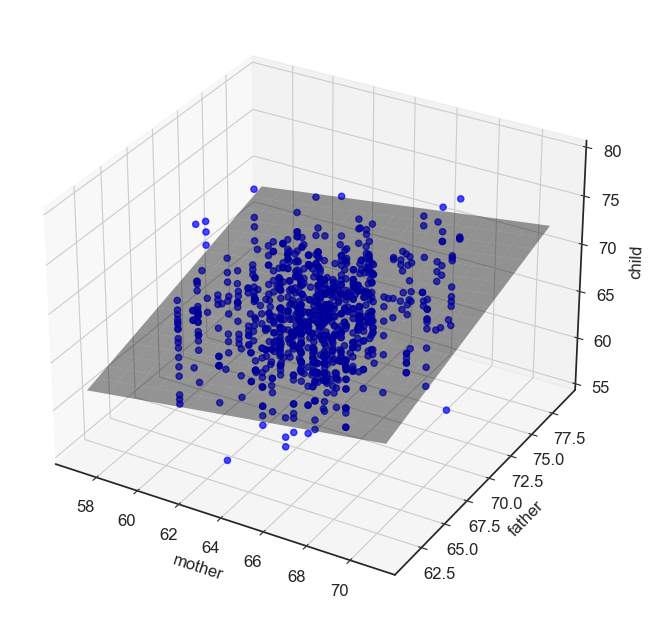

In [14]:
util.plot3Dscatter(galton, 'mother', 'father', lr, galton['childHeight'])

<AxesSubplot:xlabel='father', ylabel='childHeight'>

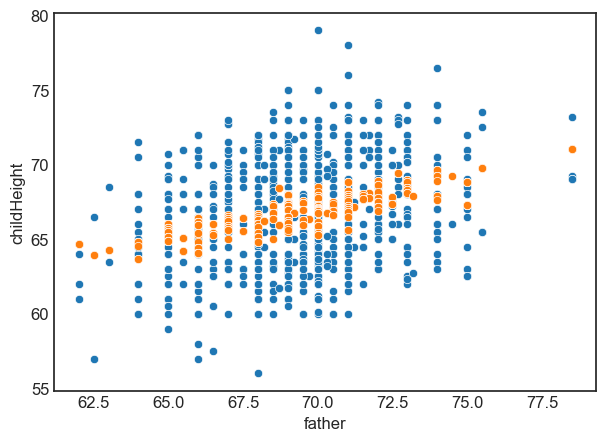

In [15]:
# plot results by father height
sns.scatterplot(x=galton['father'], y=galton['childHeight'])
sns.scatterplot(x=galton['father'], y=pd.Series(predictions))

<AxesSubplot:xlabel='mother', ylabel='childHeight'>

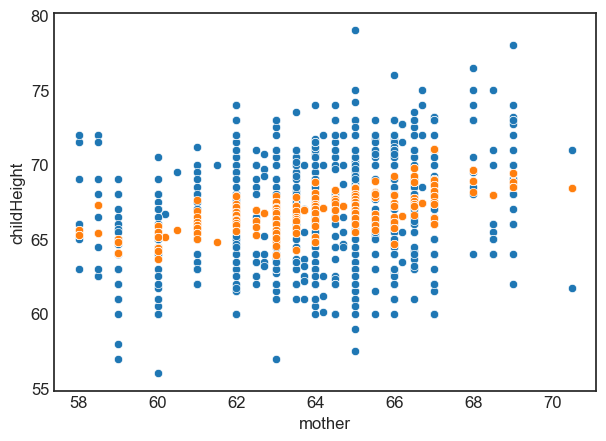

In [16]:
# plot results by mother height
sns.scatterplot(x=galton['mother'], y=galton['childHeight'])
sns.scatterplot(x=galton['mother'], y=pd.Series(predictions))

### Attempt #3: adding gender to the regression

* Our previous predictions are constant for a given set of parents.
* One would expect male/female children of the same parents to have different heights!
* Is it reasonable to add this attribute? Is it known when the prediction is used?

First plot a scatterplot of 'father height' vs 'child height' by group:

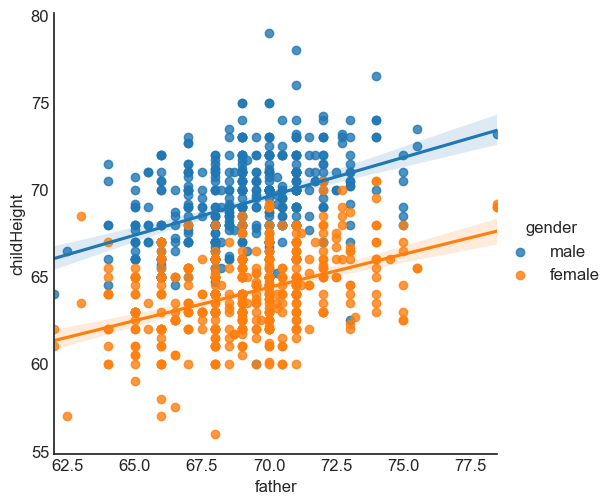

In [17]:
# The regression lines (predictions) are very different for male/female
sns.lmplot(x='father', y='childHeight', data=galton, hue='gender');

### Attempt #3: adding gender to the regression

* Problem: gender is *categorical*, while regression requires *quantitative* inputs!
    - The table contains two values in the column: male/female
* Solution: create a binary column called `gender=male` that:
    - is 1 when `gender` has value male, and
    - is 0 otherwise
    
This is a simple example of *one-hot encoding*.

In [18]:
galton['gender=male'] = (galton.gender == 'male').astype(int)
galton.head()

,family,father,mother,children,childNum,gender,childHeight,gender=male
0,1,78.5,67.0,4,1,male,73.2,1
1,1,78.5,67.0,4,2,female,69.2,0
2,1,78.5,67.0,4,3,female,69.0,0
3,1,78.5,67.0,4,4,female,69.0,0
4,2,75.5,66.5,4,1,male,73.5,1


In [19]:
lr_gender = LinearRegression()
lr_gender.fit(galton[['father', 'mother', 'gender=male']], galton.childHeight)

LinearRegression()

In [20]:
predictions_gender = lr_gender.predict(galton[['father', 'mother', 'gender=male']])

In [21]:
np.sqrt(np.mean(np.abs(predictions_gender - galton.childHeight )**2))

2.160050676202806

<AxesSubplot:xlabel='father', ylabel='childHeight'>

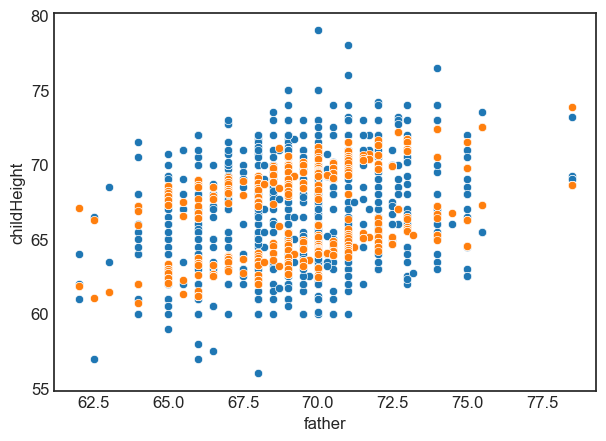

In [22]:
# plot results by father height
sns.scatterplot(x=galton['father'], y=galton['childHeight'])
sns.scatterplot(x=galton['father'], y=pd.Series(predictions_gender))

### Visualizing regression with one-hot encoding

* One-hot encoding "pulls the two genders apart" in the scatterplot, along a 3rd dimension.

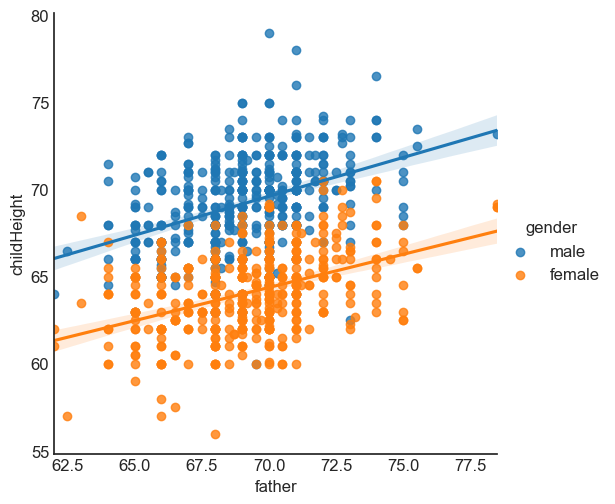

In [23]:
# The regression lines (predictions) are very different for male/female
sns.lmplot(x='father', y='childHeight', data=galton, hue='gender');

In [24]:
lr_gender_2 = LinearRegression()
lr_gender_2.fit(galton[['gender=male', 'father']], galton.childHeight)


LinearRegression()

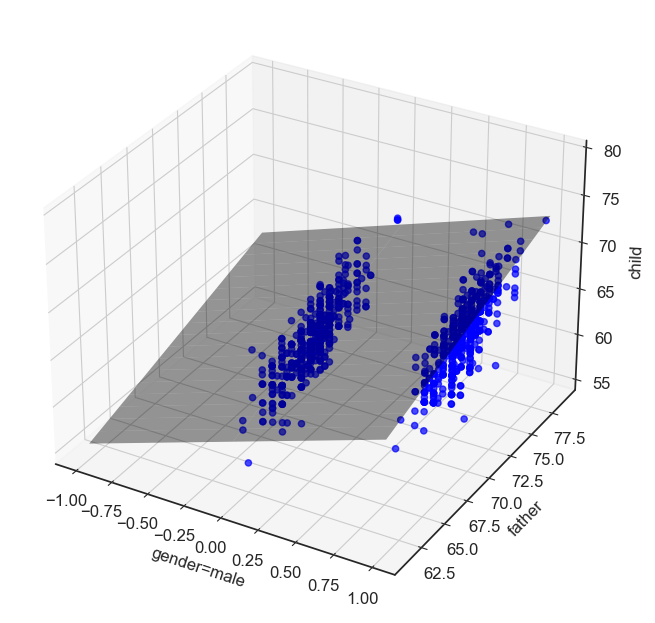

In [25]:
util.plot3Dscatter(galton, 'gender=male', 'father', lr_gender_2, galton['childHeight'])

## Feature Engineering

## The goal of feature engineering

* Find transformations that effectively transform data into effective quantitative variables

* Find functions $\phi:{\rm DATA}\to\mathbb{R}^d$ where similar points $x,y\in {\rm DATA}$ have close images $\phi(x), \phi(y)\in \mathbb{R}^d$

* A "good" choice of features depends on many factors:
    - data type (quantitative, ordinal, nominal),
    - the relationship(s) and association(s) being modeled,
    - the model type (e.g. linear models, decision tree models, neural networks).

### Want to build a linear regression model:

<div class="image-txt-container">
    
* On a dataset of product review data (X),
* To understand the relationship to product ratings (Y).
* Using "plane of best fit"

<img src="imgs/plane.jpg">

</div>


### Want to build a linear model

* Why can't a linear model be built review data directly?
* What needs to happen to build the model?
* What are concrete steps to take?

|UID|AGE|STATE|HAS_BOUGHT|REVIEW|\||RATING|
|---|---|---|---|---|---|---|
|0|32|NY|True|"Meh."|\||&#10025;&#10025;|
|42|50|WA|True|"Worked out of the box..."|\||&#10025;&#10025;&#10025;&#10025;|
|57|16|CA|NULL|"Hella tots lit yo..."|\||&#10025;|
|...|...|...|...|...|\||...|
|(int)|(int)|(str)|(bool)|(str)|\||(str)|

### Basic Transformations: uninformative features

`UID` was likely used to join the user information (e.g., `age`, and `state`) with some `Reviews` table.  The `UID` presents several questions:
* What is the meaning of the `UID` *number*? 
* Does the magnitude of the `UID` reveal information about the rating?
* Does adding `UID` improve our model?
* **Transformation:** drop the feature.

### Dropping Features

There are certain scenarios where manually dropping features might be helpful:

1. when the features **does not to contain information** associated with the prediction task.  
2. when the feature is **not available at prediction time.**  For example, the feature might contain information collected after the user entered a rating.  This is a common scenario in time-series analysis.


### Basic Transformations: scaling features

`AGE` might contain corrupted or 'clumped' data that requires scaling:
- **Transformation:** apply binning to discretize the data into quartiles.
- **Transformation:** apply non-linear transformation (e.g. log, sqrt).
- **Transformation:** normalize/standardize (z-scale; range).

### Basic Transformations: ordinal encoding

How to encode the `RATING` column as a quantitative variable?
* **Transformation:** "number of &#10025;" to "number".
    - Called *ordinal encoding*: map the ordinal values onto the integer, preserving order.
* Does this preserve "distances" between ratings? (yes).
    

In [26]:
order_values = ['✩', '✩✩', '✩✩✩', '✩✩✩✩', '✩✩✩✩✩']
ordinal_enc = {y:x for (x,y) in enumerate(order_values)}
ordinal_enc

{'✩': 0, '✩✩': 1, '✩✩✩': 2, '✩✩✩✩': 3, '✩✩✩✩✩': 4}

In [27]:
ratings = pd.Series(['✩', '✩✩', '✩✩✩', '✩✩', '✩✩✩', '✩', '✩✩✩', '✩✩✩✩', '✩✩✩✩✩'], name='RATING')
ratings.to_frame()

,RATING
0,✩
1,✩✩
2,✩✩✩
3,✩✩
4,✩✩✩
5,✩
6,✩✩✩
7,✩✩✩✩
8,✩✩✩✩✩


In [28]:
ratings
ratings.replace(ordinal_enc)

0    0
1    1
2    2
3    1
4    2
5    0
6    2
7    3
8    4
Name: RATING, dtype: int64

### Basic Transformations: one-hot encoding

How to encode the `STATE` column as a quantitative variable?
- How do we make STATE into a meaningful number?
- Ordinal Encoding? AL=1,...,WY=50? (No!)
- **Transformation:** 50 binary variables: `is_AL`,...,`is_WY`.

## Nominal feature encoding: One hot encoding

* Transform categorical features into many binary features.
* Given a column `col` with values `A1,A2,...A_N`, define the following quantitative binary columns:

$$\phi_i(x) = \left\{\begin{array}{ll}1 & {\rm if\ } x = A_i \\ 0 &  {\rm if\ } x\neq A_i \\ \end{array}\right. $$

* *Also called:* dummy encoding; indicator variables.

### Example: one hot encoding States

* A column containing US states transforms into 50 feature columns
* e.g. `phi_CA(x) = 1 if x == 'CA' else 0`
* Oftentimes, many of these columns will be *largely* 0.

<img src="imgs/image_4.png">

In [29]:
df = pd.DataFrame([['NY'], ['WA'], ['CA'], ['NY'], ['OR']], columns=['STATE'])
df

,STATE
0,NY
1,WA
2,CA
3,NY
4,OR


In [30]:
states = df.STATE.unique()
states

array(['NY', 'WA', 'CA', 'OR'], dtype=object)

In [31]:
# row by row

df['STATE'].apply(lambda x: pd.Series(x == states, index=states, dtype=float))

,NY,WA,CA,OR
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0


## Features and Models

Feature engineering transforms data into quantitative attributes, such that 
* similar observations are close in the feature space.
* the features are presented in a way usable for the desired model.


The quality of a feature is measured by the question being asked and the appropriateness for model used.


### The missing step: data to models

* Modeling techniques typically require *quantitative* input.
* Models require (strong) relationships between X and Y.

<img src="imgs/image_1.png">

There is work to be done transforming data into effective features!

## Introduction to Modeling

* Data Generating Process: The real-word phenomena from which data are collected.
    - *Example:* Every year, city employees gain/lose employment, earning a salary.
    - Can't observe this process directly.
* Model: a theory about the Data Generating Process:
    - *Example:* If an employee is X years older than average, then they will make significantly more in salary. 
    - How is this model created?
* Fit Model: a model specified to a particular set of observations (dataset).
    - *Example:* If an employee is 5 years older than average, they will make significantly more in salary.
    - How is this estimate determined? What makes it "good"?

### What questions can models answer?

* Questions of *Prediction*: Given what I've seen, what is the most likely value I'll see in the future?
    - Prediction forecasts the values of the data coming from the data generating process.
* Questions of *(Statistical) Inference*: How likely is what I observed representative of the broader picture?
    - Statistical Inference draws conclusions (with confidence) about the structure of the data generating process (*population*).

### Statistical Model: Inference

* A **statistical model** is a quantitative relationship between properties in observed data.
* A *statistical model* is a function $S:X\to\mathbb{R}^n$ that measures properties of $X$.
* **Example:** Is there a linear relationship between the heights of children and the height of their biological mother?
    * $X = \texttt{mother_height} = \mathbb{R}$
    * $Y = \texttt{child_height} = \mathbb{R}$
    * $S$ is the correlation coefficient
    
Inference results in interpreting properties of the DGP from the parameters of the model (correlation).

### Prediction Model: Regression

* **Regression Models** attempt to predict the most likely quantitative value associated to an observation (feature).
* A *regressor* is a function $R:X\to \mathbb{R}$ that predicts the value $y\in \mathbb{R}$ of an observation $x\in X$.
* **Example:** Given the heights of a child's parents, what is the height of their child?
    * $X = (\texttt{father_height, mother_height}) = \mathbb{R}^2$
    * $Y = \texttt{child_height} = \mathbb{R}$
    * $C$ predicts child heights.

### Prediction Model: Classification

* **Classification Models** attempt to predict the most likely *class* associated to an observation (feature).
    - The *type* or *class* is a *nominal* attribute (e.g. 'YES' or 'NO').

* A *classifier* is a function $C:X\to Y$ that predicts whether an observation $x\in X$ belongs to class $y\in Y$.

* **Example:** Given product purchase attributes (item, price, age, state), can one predict whether the person was satisfied with their purchase?
    - $X = \{(\texttt{item, price, age, state})\}$
    - $Y = \{\texttt{'SATISFIED'}, \texttt{'NOT SATISFIED'}\}$
    - $C$ predicts product satisfaction.

# Example: Restaurant Tips 

## Example

* Data: collected by a single waiter over a month.
* Why build a model?
    - Predict which tables will tip the highest? (Optimize your service)
    - Predict a waiter's income for the year. (Regression)
    - Understand relationship between diners and tips. (Inference)
    

*Can we predict tip amounts from the total bill? (Prediction; Regression)*
    
Credit: Joseph Gonzalez, DS100 (UC Berkeley)

In [32]:
tips = sns.load_dataset('tips')
print('number of records: ', len(tips))

number of records:  244


In [33]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


## EDA

* How does the total bill differ from tip amount?
* Are there outliers in the tips?
* What do tips "look like"?

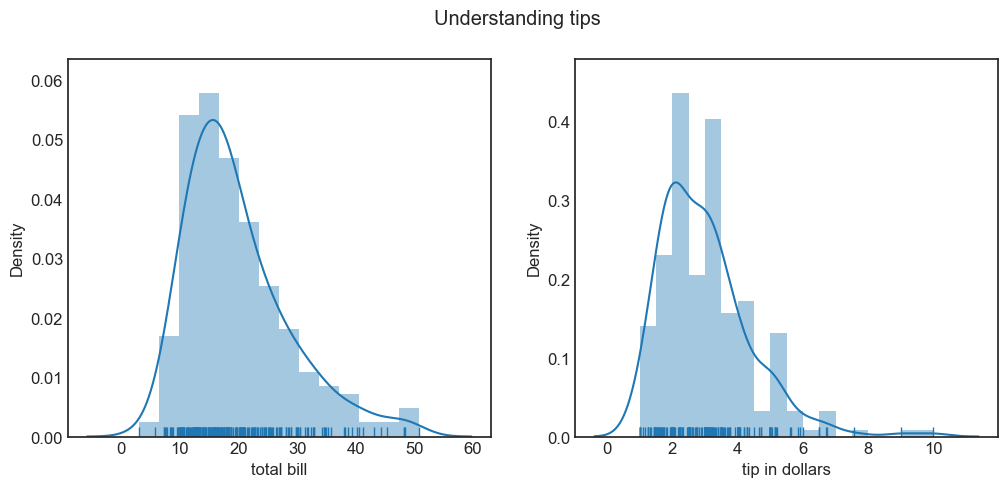

In [34]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

sns.distplot(tips.total_bill, rug=True, ax=axes[0])
axes[0].set_xlabel('total bill')

sns.distplot(tips.tip, rug=True, ax=axes[1])
axes[1].set_xlabel('tip in dollars')

fig.suptitle('Understanding tips');

#### Observations:
|Total Bill|Tip Amount|
|---|---|
|Right skewed|Right skewed|
|Mode around \$15|Mean around 3|
|Mean around \$20|Possibly bimodal (?)|
|No large bills|Large outliers (?)|

### An initial model: Constant

Suppose our model assumes every tip is given by a constant dollar amount:

$$\texttt{tip} = \theta^* \quad\leftarrow (^* {\rm \: means\: true\: parameter\: determined\: by\: universe})$$

* Model: There is a single tip amount $\theta^*$ that all customers pay.
    - Correct? No! What are reasons that other amount may be present in data?
    - Useful? Perhaps. An estimate $\theta^*$ allows us to predict future tips. Have to start somewhere!
    
* The parameter $\theta^*$ is determined by the universe (data generating process)
    - We can't observe the parameter; we need to *estimate $\theta^*$ from the data*.
    - Could be different for a different restaurant!

## All models are wrong...

"...but some are useful."

> "Since all models are wrong the scientist cannot obtain a "correct" one by excessive elaboration. On the contrary following William of Occam he should **seek an economical description of natural phenomena**. Just as the ability to devise simple but evocative models is the signature of the great scientist so overelaboration and overparameterization is often the mark of mediocrity."

> "Since all models are wrong the scientist must be alert to what is importantly wrong. It is inappropriate to be concerned about mice when there are tigers abroad."

~ George Box

### How to estimate the parameter $\theta^*$

* Use *prior knowledge*: a coffee shop? \\$1? a diner \\$5? Even bill amounts?
* Use the data!
    - Calculate use the mean? median? mode?
* Which is the best estimate? which model 'fits' the data best?
    - Depends on the goal and the problem
    - Should measure how "close" the predictions are to the true values.

### Constant model attempt

* Constant model: assume every tip is a constant value -- the mean tip of ~\\$3.
* How good is this model? How wrong are its predictions?
* Measure error using a **loss function**:
    - Root Mean Square Error: $${\rm RMSE} = \sqrt{\frac{1}{N}\sum(R(x_i) - y_i)^2}$$
    - Mean Absolute Error: $${\rm MAE} = \frac{1}{N}\sum|R(x_i) - y_i|$$

Where $x_i$ are the observations, $y_i$ are the true values, and $R$ is the prediction function (regressor).

In [35]:
# Constant guess amount
mean_tip = tips.tip.mean()
mean_tip

2.99827868852459

In [36]:
diffs = (mean_tip - tips.tip)
preds = tips[['total_bill', 'tip']].assign(
    prediction=mean_tip,
    error=lambda x:(x['tip'] - x['prediction'])
)
preds.head()

,total_bill,tip,prediction,error
0,16.99,1.01,2.998279,-1.988279
1,10.34,1.66,2.998279,-1.338279
2,21.01,3.50,2.998279,0.501721
3,23.68,3.31,2.998279,0.311721
4,24.59,3.61,2.998279,0.611721


In [37]:
# MAE -- in dollar amounts!
preds.error.abs().mean()

1.0330186777747916

In [38]:
# RMSE -- in dollar amounts!
(preds.error**2).mean()**0.5

1.3807999538298954

### Was there a better choice than using the (historical) mean tip?

If we want the model that has the smallest RMSE possible:

$${\rm RMSE} = \sqrt{\frac{1}{N}\sum(\hat\theta - t_i)^2}$$

To minimize, can ignore the square root:

$$RMSE = \frac{1}{N}\sum_{i=1}^{N}(\hat\theta - t_i)^2$$

Set derivative of the RMSE to zero:

$$0 = \frac{2}{N}\sum_{i=1}^{N}(\hat\theta - t_i) = \frac{2N\hat\theta}{N} - \frac{2}{N}\sum_{i=1}^{N}t_i$$

Solving for $\hat\theta$ gives:

$$\hat\theta = \frac{1}{N}\sum_{i=1}^{N}t_i$$

So our model parameter was *best* choice (for our chosen loss function, RMSE).

### A Derived Feature: Can it help our model?

* A *derived feature* might help explain tip amounts: $$\texttt{pct_tip} = \frac{\texttt{tip}}{\texttt{total_bill}}$$

* Example of quantitative scaling!
* Natural representation of tips: in US, custom is to tip a percentage.
* What is the data quality assessment of this quantitative transformation?

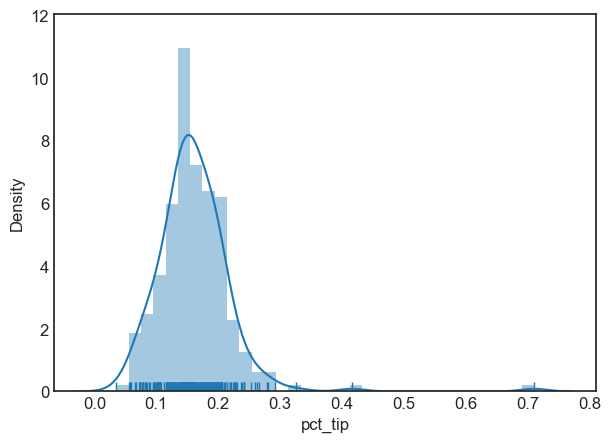

In [39]:
tips = tips.assign(pct_tip=(tips['tip'] / tips['total_bill']))
sns.distplot(tips['pct_tip'], rug=True);

### A new constant model: derived features

Suppose our model assumes every tip is given by a constant `pct_tip`:

$$\texttt{pct_tip} = \theta^* \quad\leftarrow (^* {\rm \: Means\: true\: parameter\: determined\: by\: universe})$$

* Model: There is a percent tip $\theta^*$ that all customers pay.
    - Correct? No! What are reasons that other percentages may be present in data?
    - Useful? Perhaps. A good estimate $\theta^*$ could allows us to predict future tips.
    
* The parameter $\theta^*$ is determined by the universe (data generating process)
    - We can't observe the parameter; we need to *estimate $\theta^*$ from the data*.

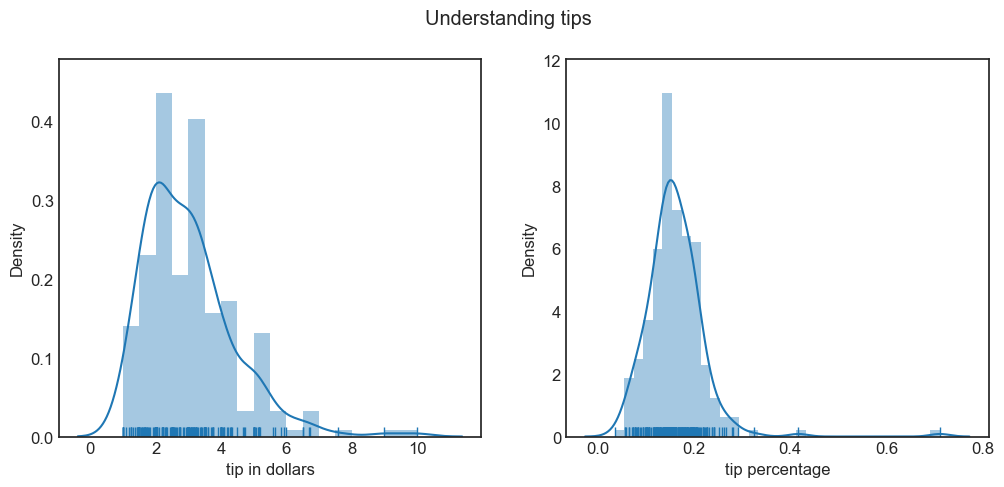

In [40]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

sns.distplot(tips.tip, rug=True, ax=axes[0])
axes[0].set_xlabel('tip in dollars')

sns.distplot(tips['pct_tip'], rug=True, ax=axes[1])
axes[1].set_xlabel('tip percentage')

fig.suptitle('Understanding tips');

### How to estimate the parameter $\theta^*$

* Use *prior knowledge*: e.g. 15%
* Use the data!
    - Calculate the percentage from a random selection of tables? Use the mean? median? mode?
* Which is the best estimate? which model 'fits' the data best?
    - Depends on the goal and the problem
    - Should measure how "close" the predictions are to the true values.

In [41]:
diffs = (tips.total_bill * 0.15) - tips.tip

In [42]:
# MAE
diffs.abs().mean()

0.7707192622950819

In [43]:
# RMSE
(diffs**2).mean()**0.5

1.093891303284581

### Conclusion: constant model with derived feature

* Tipping 15% has better RMSE than the *best* constant (dollar amount) model!
* The error is still close to a dollar per tip, on average!
    - The average tip is only 3 dollars...
* Can we do better? new features? a more complex model?

### Attempt #3: linear model

* Build a model with no derived features, but more complex than a constant model.
* Model: tips are made according to a linear function the entire total bill:
    - The model parameter $\theta^*$ consists of the *slope* and *y-intercept*.
    - Linear regression model fits the *best* linear predictor for RMSE.
* To be appropriate, a "linear assumption" must hold!

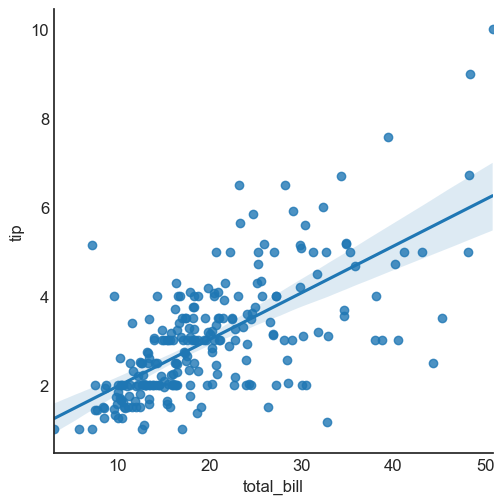

In [44]:
sns.lmplot(data=tips, x='total_bill', y='tip');

In [45]:
from scipy.stats import linregress
lr = linregress(tips.total_bill, tips.tip)

In [46]:
# regression coefficients
m, b = lr.slope, lr.intercept
m, b

(0.10502451738435334, 0.9202696135546735)

In [47]:
preds = m * tips.total_bill + b
preds.head()

0    2.704636
1    2.006223
2    3.126835
3    3.407250
4    3.502822
Name: total_bill, dtype: float64

In [48]:
# RMSE
errors = preds - tips.tip
(errors ** 2).mean() ** 0.5

1.0178504025697377

### Conclusion: Linear model

* Best linear predictor (for RMSE)! Why is it necessarily better than our "constant percentage model"?
* Tip ~\\$1 upfront (intercept), then at ~10.5% for every dollar thereafter (slope).
* But is a linear model the *best model choice*?
    - This is an inference problem (what does the data look like 'in general'?)
    - Use $R^2$ for 'goodness of fit'
    - Beware of heteroskedasticity, multicolinearity, etc...

# Example: Adding features to predict tips


In [49]:
tips = sns.load_dataset('tips')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


### One hot encoding categorical variables
* Are all of these variable nominal?
* Do we have redundant variables we can drop?

In [50]:
categorical_cols = ['sex', 'smoker', 'day', 'time']

In [51]:
features = tips.copy().loc[:,['total_bill', 'size']]
for c in categorical_cols:
    for val in tips[c].unique():
        features['%s=%s' %(c, val)] = (tips[c] == val).astype(int)

In [52]:
features.head()

,total_bill,size,sex=Female,sex=Male,smoker=No,smoker=Yes,day=Sun,day=Sat,day=Thur,day=Fri,time=Dinner,time=Lunch
0,16.99,2,1,0,1,0,1,0,0,0,1,0
1,10.34,3,0,1,1,0,1,0,0,0,1,0
2,21.01,3,0,1,1,0,1,0,0,0,1,0
3,23.68,2,0,1,1,0,1,0,0,0,1,0
4,24.59,4,1,0,1,0,1,0,0,0,1,0


In [53]:
tips.shape

(244, 7)

In [54]:
features.shape

(244, 12)

In [55]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(features, tips.tip)

LinearRegression()

In [56]:
# Error is a few cents less than previous
np.sqrt(np.mean((lr.predict(features) - tips.tip)**2))

1.0051634500049158

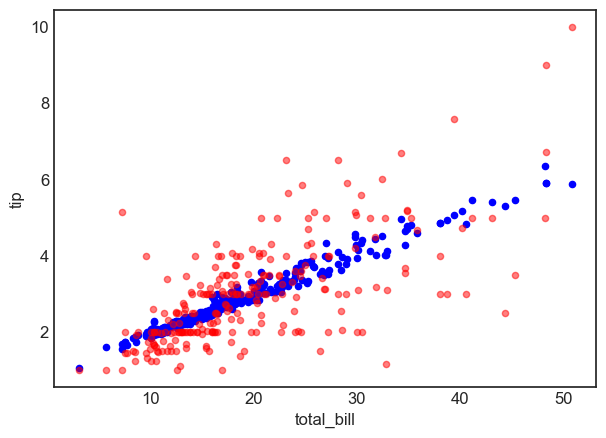

In [57]:
preds = lr.predict(features)
a = pd.concat([tips.total_bill, pd.Series(preds).rename('prediction'), tips.tip], axis=1)
ax = plt.subplot()
a.plot(kind='scatter', x='total_bill', y='prediction', ax=ax, c='b')
a.plot(kind='scatter', x='total_bill', y='tip', ax=ax, c='r', alpha=0.5);

### Transformations of quantitative features
* Transforming quantitative features can enhance 'hidden trends' in data.
* Examples:
    - Growth rates scaled to linear trends (e.g. log, sqrt)
    - Periodic trends separated from growth (e.g. sin)
    - Group-wise scaling
    - Interactions between variables (e.g. polynomial encoding)

### Example: de-trending periodic sales

* Daily sales volume from an e-commerce product
* Like to predict future sales, based on current trends:
    - What seasonality (periodicity) is present?
    - What is long-run growth? (linear? quadratic? exponential?)
    - Can you guess a feature that models these properties?


In [58]:
df = pd.read_csv('data/sinusoidal.csv').sort_values(by='day').reset_index(drop=True)

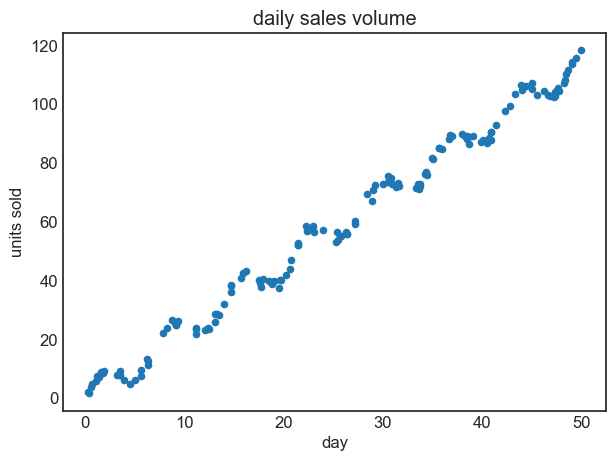

In [59]:
df.plot(kind='scatter', x='day', y='units sold', title='daily sales volume');

### Example: de-trending periodic sales

* Periodic sales by week (7-day period).
* Sales have ~10x difference between low and high (amplitude).
* Sales is approximately 'linear growth + periodic term'
* Feature:
$$ \phi(x) = x + 5\sin\left(\frac{2\pi\cdot x}{7}\right) $$

In [60]:
def detrend(day):
    '''
    Periodic sales volume by the week.
    Sales sees ~10x weekly difference between low and high.
    '''
    return day +  5 * np.sin(2 * np.pi * day / 7)

In [61]:
df['detrend'] = detrend(df['day'])

<AxesSubplot:xlabel='day'>

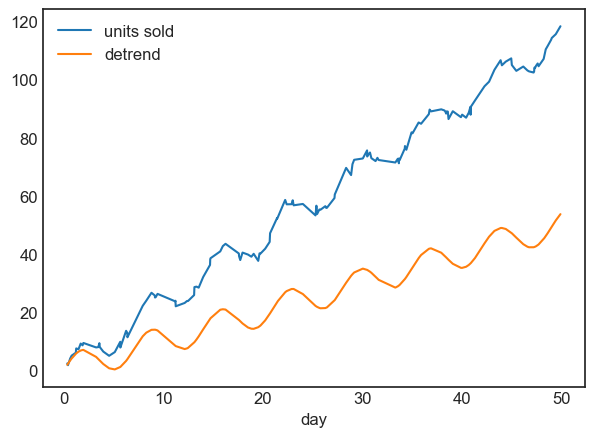

In [62]:
df.set_index('day').sort_index().plot()

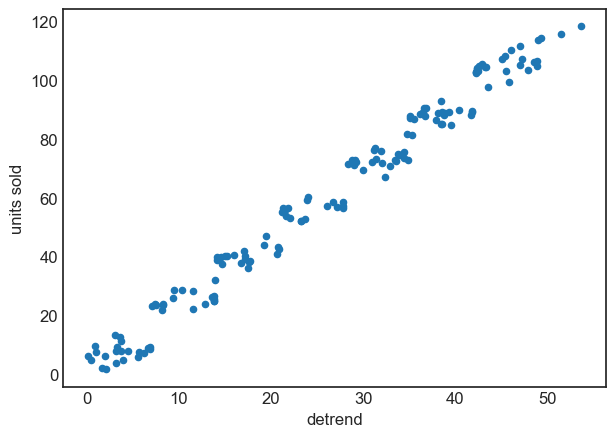

In [63]:
# feature space vs target space
# linear relationship!
df[['units sold', 'detrend']].plot(kind='scatter', x='detrend', y='units sold');

<AxesSubplot:xlabel='day', ylabel='units sold'>

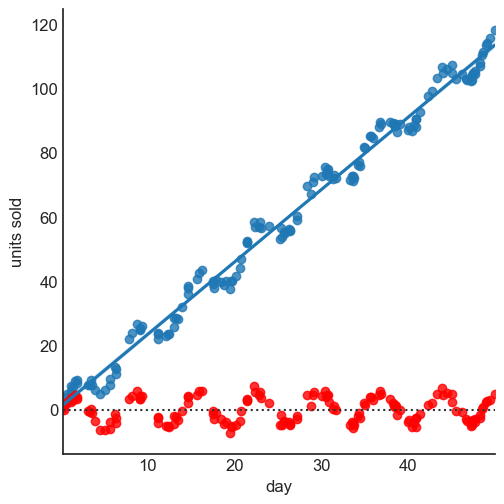

In [64]:
sns.lmplot(data=df, x='day', y='units sold')
sns.residplot(data=df, x='day', y='units sold', color='r')

<AxesSubplot:xlabel='detrend', ylabel='units sold'>

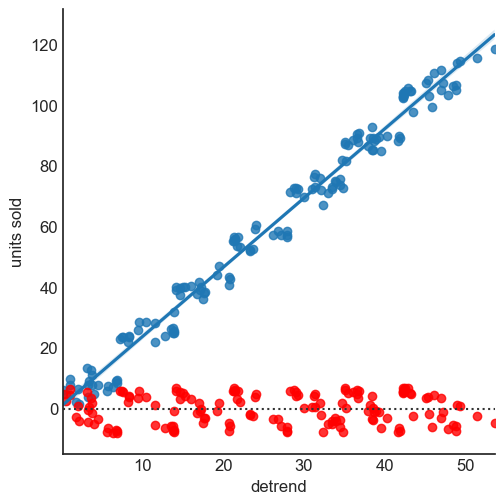

In [65]:
sns.lmplot(data=df, x='detrend', y='units sold')
sns.residplot(data=df, x='detrend', y='units sold', color='r')